# <center>Using Machine Learning in Urban Planning</center>

<center>by Meng Cai</center>

---

Machine learning (ML) could probably help my boss and I categorize comments into predefined topics. This is currently done by human labor. It costs my boss some money and costs me a lot of time doing tedious proofread.

# The problem and dataset

The example dataset contains roughly 500 comments with categories labeled by humans. The comments were collected by a Michigan state-wide on-board intercept surveys with current public transit users. The goal is to train a model to auto tag their comments. Since the survey is ongoing, if I have any luck with a ML model, I will be benefit from it for the next two years.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def ImportData(file, text_column):
    raw = pd.read_csv(file, encoding="ISO-8859-1")
    df = raw[~raw[text_column].isnull()] 
    df = df[df[text_column].str.contains("illegible|Illegible|N/A")==False]
    return df

In [3]:
def CommentCleaner(dirty_text):
    dirty_text = dirty_text.replace("&amp", "")
    semi_clean_text = " ".join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", dirty_text).split())
    clean_text = " ".join(re.sub(r"\d+", "", semi_clean_text).split())
    return clean_text

In [4]:
def LabelCat(x):
    if x=="Satisfied with services":
        return 1
    elif x=="Schedules/timeliness issues":
        return 2
    elif x=="Routes":
        return 3
    elif x=="Vehicles":
        return 4
    elif x=="Personnel":
        return 5
    elif x=="Cost":
        return 6
    elif x=="Other":
        return 7

In [5]:
df=ImportData("comments.csv", "comment")
clean=[]
label=[]
for com in df["comment"]:
    clean.append(CommentCleaner(com))
for cat in df["category"]:
    label.append(LabelCat(cat))
df["clean_comment"]=clean
df["label"]=label
df

comment  \
0                                        great service   
1                       helpful when my car brake down   
2    Theyâve been perfect for me. I do not know w...   
3    dial a ride is a good reliable services and i ...   
4                                   i think it's great   
..                                                 ...   
570  8. I love dial a ride it gives me freedom to g...   
571  9. I would be lost without having Dial-a-ride,...   
572  1. They need to pick you up on time and pick y...   
573    2. Could benefit from longer operation times .    
574                                        wider buses   

                        category  \
0        Satisfied with services   
1        Satisfied with services   
2        Satisfied with services   
3        Satisfied with services   
4        Satisfied with services   
..                           ...   
570      Satisfied with services   
571      Satisfied with services   
572  Schedules/timeliness issues   
573  Schedules/timeliness issues   
574                     Vehicles   

                                         clean_comment  label  
0                                        great service      1  
1                       helpful when my car brake down      1  
2    They ve been perfect for me I do not know what...      1  
3    dial a ride is a good reliable services and i ...      1  
4                                   i think it s great      1  
..                                                 ...    ...  
570  I love dial a ride it gives me freedom to get ...      1  
571  I would be lost without having Dial a ride I d...      1  
572  They need to pick you up on time and pick you ...      2  
573          Could benefit from longer operation times      2  
574                                        wider buses      4  

[570 rows x 4 columns]

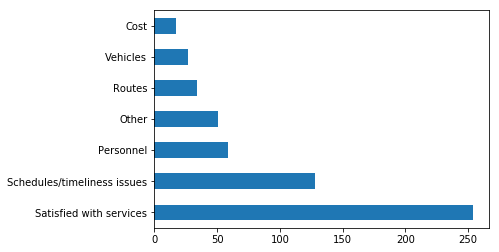

In [6]:
df.category.value_counts().plot.barh()

We can see that the distribution of comment themes is imbalanced. Michigan bus riders are more likely to be satisfied with their transit service or have issues with bus schedules than complain about ticket prices or vehicles. I have read that ML algorithms tend to be biased towards the majority class. However, in this case, I do desire to have a model that gives high prediction accuracy over the majority class. The minority classes are rare anyway and I can fix them when doing human proofreading. So, I left the distribution as it is.

---

# Using scikit-learn

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [8]:
comments=df["clean_comment"].values
y=df["label"].values
comments_train,comments_test,y_train,y_test=train_test_split(comments,y,test_size=0.3, random_state=100)

# Baseline models

In [9]:
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(comments_train)

x_train=vectorizer.transform(comments_train)
x_test=vectorizer.transform(comments_test)

In [10]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Networks", 
         "Ada Boost","Naive Bayes", "Logistic Regression"]

classifiers = [KNeighborsClassifier(3), 
               SVC(kernel="linear", C=0.025), 
               SVC(gamma="auto", C=1),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=40, max_features=1),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier(),
               MultinomialNB(),
               LogisticRegression(solver="liblinear", multi_class="ovr")]

scores =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train,y_train)
    scores.append(classifier.score(x_test, y_test))

#  Term frequency – inverse document frequency (tf-idf)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Unigrams + stopwords removal

In [12]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             stop_words="english", 
                             min_df = 1, # the minimum numbers of documents a word must by present in to be kept 
                             sublinear_tf=True,  # to use a logarithmic form for frequency
                             norm = "l2", # to ensure all feature vectors have a euclidian norm of 1
                             ngram_range=(1,1)) # to consider only unigrams not bigrams
vectorizer.fit(comments_train)

x_train=vectorizer.transform(comments_train)
x_test=vectorizer.transform(comments_test)

scores_tfidf_unigram =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train,y_train)
    scores_tfidf_unigram.append(classifier.score(x_test, y_test))

## Bigrams + stopwords removal

In [13]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             stop_words="english", 
                             min_df = 1, 
                             sublinear_tf=True, 
                             norm = "l2", 
                             ngram_range=(1,2)) 
vectorizer.fit(comments_train)

x_train=vectorizer.transform(comments_train)
x_test=vectorizer.transform(comments_test)

scores_tfidf_bigram =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train,y_train)
    scores_tfidf_bigram.append(classifier.score(x_test, y_test))

## Unigrams + keep stopwords

In [14]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             min_df = 1, 
                             sublinear_tf=True,  
                             norm = "l2", 
                             ngram_range=(1,1)) 
vectorizer.fit(comments_train)

x_train=vectorizer.transform(comments_train)
x_test=vectorizer.transform(comments_test)

scores_tfidf_unigram_stopword =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train,y_train)
    scores_tfidf_unigram_stopword.append(classifier.score(x_test, y_test))

## Bigrams + keep stopwords

In [15]:
vectorizer = TfidfVectorizer(lowercase=True, 
                             min_df = 1, 
                             sublinear_tf=True,  
                             norm = "l2", 
                             ngram_range=(1,2))
vectorizer.fit(comments_train)

x_train=vectorizer.transform(comments_train)
x_test=vectorizer.transform(comments_test)

scores_tfidf_bigram_stopword =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train,y_train)
    scores_tfidf_bigram_stopword.append(classifier.score(x_test, y_test))

In [16]:
results=pd.DataFrame()
results["classifier"]=names
results["without_tf-idf"]=scores
results["unigram+stopwords_removal"]=scores_tfidf_unigram
results["bigram+stopwords_removal"]=scores_tfidf_bigram
results["unigram+stopwords"]=scores_tfidf_unigram_stopword
results["bigram+stopwords"]=scores_tfidf_bigram_stopword
results

classifier  without_tf-idf  unigram+stopwords_removal  \
0    Nearest Neighbors        0.654971                   0.672515   
1           Linear SVM        0.631579                   0.520468   
2              RBF SVM        0.520468                   0.520468   
3        Decision Tree        0.608187                   0.438596   
4        Random Forest        0.520468                   0.520468   
5      Neural Networks        0.777778                   0.719298   
6            Ada Boost        0.619883                   0.561404   
7          Naive Bayes        0.713450                   0.654971   
8  Logistic Regression        0.771930                   0.625731   

   bigram+stopwords_removal  unigram+stopwords  bigram+stopwords  
0                  0.660819           0.713450          0.690058  
1                  0.520468           0.520468          0.520468  
2                  0.520468           0.520468          0.520468  
3                  0.432749           0.584795          0.590643  
4                  0.520468           0.520468          0.520468  
5                  0.707602           0.766082          0.730994  
6                  0.573099           0.561404          0.561404  
7                  0.631579           0.654971          0.649123  
8                  0.631579           0.672515          0.660819

# Findings so far

Logistic Regression, Naive Bayes, and Neural Networks seem to have better performance than other classifiers. However, the overall accuracy is a bit disappointing. The "best" model only has a 77% accuracy.

Tf-idf does not seem to be useful in my case. Generally speaking, removing stop words (e.g "a", "the", "I") worsens performance. Considering both unigrams (e.g. "united" and "states") and bigrams (e.g. "united states") also makes things worse.

My guess is that the "other" category is problematic. Because it was designed as a place for comments that do not  fit into defined categories. Humans can hardly find patterns in "other", let alone machines.

---

# Remove "other"

In [17]:
dfnoother=df[df["label"]!=7]
dfnoother

comment  \
0                                        great service   
1                       helpful when my car brake down   
2    Theyâve been perfect for me. I do not know w...   
3    dial a ride is a good reliable services and i ...   
4                                   i think it's great   
..                                                 ...   
570  8. I love dial a ride it gives me freedom to g...   
571  9. I would be lost without having Dial-a-ride,...   
572  1. They need to pick you up on time and pick y...   
573    2. Could benefit from longer operation times .    
574                                        wider buses   

                        category  \
0        Satisfied with services   
1        Satisfied with services   
2        Satisfied with services   
3        Satisfied with services   
4        Satisfied with services   
..                           ...   
570      Satisfied with services   
571      Satisfied with services   
572  Schedules/timeliness issues   
573  Schedules/timeliness issues   
574                     Vehicles   

                                         clean_comment  label  
0                                        great service      1  
1                       helpful when my car brake down      1  
2    They ve been perfect for me I do not know what...      1  
3    dial a ride is a good reliable services and i ...      1  
4                                   i think it s great      1  
..                                                 ...    ...  
570  I love dial a ride it gives me freedom to get ...      1  
571  I would be lost without having Dial a ride I d...      1  
572  They need to pick you up on time and pick you ...      2  
573          Could benefit from longer operation times      2  
574                                        wider buses      4  

[519 rows x 4 columns]

In [18]:
comments2=dfnoother["clean_comment"].values
y2=dfnoother["label"].values

comments_train2,comments_test2,y_train2,y_test2=train_test_split(comments2,y2,test_size=0.3, random_state=100)
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(comments_train2)

x_train2=vectorizer.transform(comments_train2)
x_test2=vectorizer.transform(comments_test2)

# Baseline models
scores_noother =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train2,y_train2)
    scores_noother.append(classifier.score(x_test2, y_test2))

In [19]:
# Unigrams + stopwords removal
vectorizer = TfidfVectorizer(lowercase=True, 
                             stop_words="english", 
                             min_df = 1, 
                             sublinear_tf=True, 
                             norm = "l2",
                             ngram_range=(1,1))
vectorizer.fit(comments_train2)

x_train2=vectorizer.transform(comments_train2)
x_test2=vectorizer.transform(comments_test2)

scores_tfidf_unigram_noother =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train2,y_train2)
    scores_tfidf_unigram_noother.append(classifier.score(x_test2, y_test2))

In [20]:
# Bigrams + stopwords removal
vectorizer = TfidfVectorizer(lowercase=True, 
                             stop_words="english", 
                             min_df = 1, 
                             sublinear_tf=True, 
                             norm = "l2", 
                             ngram_range=(1,2)) 
vectorizer.fit(comments_train2)

x_train2=vectorizer.transform(comments_train2)
x_test2=vectorizer.transform(comments_test2)

scores_tfidf_bigram_noother =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train2,y_train2)
    scores_tfidf_bigram_noother.append(classifier.score(x_test2, y_test2))

In [21]:
# Unigrams + keep stopwords
vectorizer = TfidfVectorizer(lowercase=True, 
                             min_df = 1, 
                             sublinear_tf=True,  
                             norm = "l2", 
                             ngram_range=(1,1)) 
vectorizer.fit(comments_train2)

x_train2=vectorizer.transform(comments_train2)
x_test2=vectorizer.transform(comments_test2)

scores_tfidf_unigram_stopword_noother =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train2,y_train2)
    scores_tfidf_unigram_stopword_noother.append(classifier.score(x_test2, y_test2))

In [22]:
# Bigrams + keep stopwords
vectorizer = TfidfVectorizer(lowercase=True, 
                             min_df = 1, 
                             sublinear_tf=True,  
                             norm = "l2", 
                             ngram_range=(1,2))
vectorizer.fit(comments_train2)

x_train2=vectorizer.transform(comments_train2)
x_test2=vectorizer.transform(comments_test2)

scores_tfidf_bigram_stopword_noother =[]
for classifier in classifiers:
    #print(classifier)
    classifier.fit(x_train2,y_train2)
    scores_tfidf_bigram_stopword_noother.append(classifier.score(x_test2, y_test2))

In [23]:
results2=pd.DataFrame()
results2["classifier"]=names
results2["without_tf-idf"]=scores_noother
results2["unigram+stopwords_removal"]=scores_tfidf_unigram_noother
results2["bigram+stopwords_removal"]=scores_tfidf_bigram_noother
results2["unigram+stopwords"]=scores_tfidf_unigram_stopword_noother
results2["bigram+stopwords"]=scores_tfidf_bigram_stopword_noother
results2

classifier  without_tf-idf  unigram+stopwords_removal  \
0    Nearest Neighbors        0.660256                   0.743590   
1           Linear SVM        0.679487                   0.506410   
2              RBF SVM        0.506410                   0.506410   
3        Decision Tree        0.698718                   0.589744   
4        Random Forest        0.506410                   0.506410   
5      Neural Networks        0.814103                   0.794872   
6            Ada Boost        0.641026                   0.589744   
7          Naive Bayes        0.801282                   0.685897   
8  Logistic Regression        0.788462                   0.743590   

   bigram+stopwords_removal  unigram+stopwords  bigram+stopwords  
0                  0.730769           0.769231          0.775641  
1                  0.506410           0.506410          0.506410  
2                  0.506410           0.506410          0.506410  
3                  0.570513           0.724359          0.724359  
4                  0.506410           0.506410          0.506410  
5                  0.775641           0.814103          0.801282  
6                  0.589744           0.634615          0.628205  
7                  0.666667           0.692308          0.685897  
8                  0.711538           0.743590          0.711538

## Model evaluation

Text(0.5,33,'Predicted')

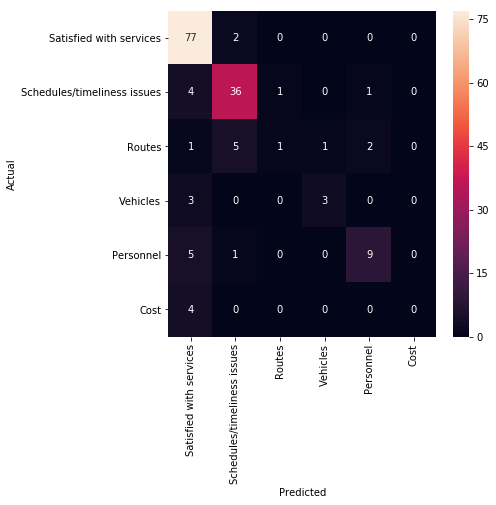

In [24]:
# check the the discrepancies between predicted and actual labels in the best-performed model

comments2=dfnoother["clean_comment"].values
y2=dfnoother["label"].values

comments_train2,comments_test2,y_train2,y_test2,indices_train, indices_test=train_test_split(comments2,y2,dfnoother.index,test_size=0.3, random_state=100)
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(comments_train2)

x_train2=vectorizer.transform(comments_train2)
x_test2=vectorizer.transform(comments_test2)

model = MLPClassifier(alpha=1, max_iter=1000)
model.fit(x_train2,y_train2)

y_pred = model.predict(x_test2)

cat_labels= ["Satisfied with services", "Schedules/timeliness issues", "Routes", "Vehicles","Personnel","Cost"]
conf_mat = confusion_matrix(y_test2, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=cat_labels, yticklabels=cat_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [25]:
print(metrics.classification_report(y_test2, y_pred, target_names=cat_labels))

                             precision    recall  f1-score   support

    Satisfied with services       0.82      0.97      0.89        79
Schedules/timeliness issues       0.82      0.86      0.84        42
                     Routes       0.50      0.10      0.17        10
                   Vehicles       0.75      0.50      0.60         6
                  Personnel       0.75      0.60      0.67        15
                       Cost       0.00      0.00      0.00         4

                   accuracy                           0.81       156
                  macro avg       0.61      0.51      0.53       156
               weighted avg       0.77      0.81      0.77       156



/Users/mengcai/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# test with brand new data
new=ImportData("comments2.csv", "comment")
clean=[]
label=[]
for com in new["comment"]:
    clean.append(CommentCleaner(com))
for cat in new["category"]:
    label.append(LabelCat(cat))
new["clean_comment"]=clean
new["label"]=label

new_comments=new["clean_comment"].values
true_y=new["label"].values

new_x=vectorizer.transform(new_comments)

new_pred=[]
for x in new_x:
    new_pred.append(model.predict(x))
new["pred"]=new_pred
target_names= ["Satisfied with services", "Schedules/timeliness issues", "Routes", "Vehicles","Personnel","Cost","Other"]
print(metrics.classification_report(true_y, new_pred,target_names=target_names))

                             precision    recall  f1-score   support

    Satisfied with services       0.73      0.99      0.84        78
Schedules/timeliness issues       0.69      0.81      0.74        36
                     Routes       0.50      0.12      0.19        17
                   Vehicles       0.50      0.25      0.33         4
                  Personnel       0.43      0.38      0.40         8
                       Cost       0.67      0.31      0.42        13
                      Other       0.00      0.00      0.00        11

                   accuracy                           0.69       167
                  macro avg       0.50      0.41      0.42       167
               weighted avg       0.62      0.69      0.63       167



In [27]:
new

comment  \
0                                           I love it.   
1    I'm happy with transportation overall me and m...   
2    For hours- it would be great if service was av...   
3    Would be nice if it runs on Sunday and later o...   
4    Anything they can do to expand would help my l...   
..                                                 ...   
162  the drivers could be more friendly notice no o...   
163  would like it if the bus made pick up in Ithac...   
164    It's perfect, but I would expanded county wide.   
165  I look forward to having all county services, ...   
166  I like dial-a-ride but there should be a cheap...   

                        category  \
0        Satisfied with services   
1        Satisfied with services   
2    Schedules/timeliness issues   
3    Schedules/timeliness issues   
4        Satisfied with services   
..                           ...   
162                    Personnel   
163                       Routes   
164                       Routes   
165                       Routes   
166                         Cost   

                                         clean_comment  label pred  
0                                            I love it      1  [1]  
1    I m happy with transportation overall me and m...      1  [1]  
2    For hours it would be great if service was ava...      2  [2]  
3    Would be nice if it runs on Sunday and later o...      2  [2]  
4    Anything they can do to expand would help my l...      1  [1]  
..                                                 ...    ...  ...  
162  the drivers could be more friendly notice no o...      5  [5]  
163  would like it if the bus made pick up in Ithac...      3  [2]  
164      It s perfect but I would expanded county wide      3  [1]  
165  I look forward to having all county services w...      3  [6]  
166  I like dial a ride but there should be a cheap...      6  [2]  

[167 rows x 5 columns]

When tested with a new dataset, the model achieved 70% accuracy.

---

# Using TensorFlow

In [28]:
from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [29]:
input_dim = x_train2.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                9070      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 9,081
Trainable params: 9,081
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x_train2, y_train2, epochs=200,verbose=False,validation_data=(x_test2, y_test2),batch_size=30)

In [31]:
loss_train, accuracy_train = model.evaluate(x_train2, y_train2, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train))
loss_test, accuracy_test = model.evaluate(x_test2, y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

Training Accuracy: 0.4821
Testing Accuracy:  0.5064


---

# Summary

I must have done something very wrong with TensorFlow. I experimented with different epochs and batch sizes, the accuracy is always around 50%.

Removing "other" category does improve ML models overall. Logistic Regression, Naive Bayes, and Neural Networks still have better performance than other classifiers. The "best" model (Neural Networks) reached a 80% accuracy. However, when validated with another dataset, the prediction accuracy is down to 70%.

In addition, in practice, it makes no sense to pre-sort riders' comments to "other" and "not_other". **My great hope is to let some algorithms to identify and relabel those comments with poor prediction accuracy with "other".** I had a hard time googling the solution. If you have any idea about how to write this code, please let me know. I would highly appreciate it.

---
# References

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

https://realpython.com/python-keras-text-classification/